In [1]:
gene_familly = None

In [2]:
# Parameters
gene_familly = "WOX"


<div style="hwidth: 100%; background-color: #ddd; overflow:hidden; ">
    <div style="display: flex; justify-content: center; align-items: center; border-bottom: 10px solid #80c4e7; padding: 3px;">
        <h2 style="position: relative; top: 3px; left: 8px;">S2 Project: DNA Classification - (part2: Approach 2)</h2>
        <!--<img style="position: absolute; height: 68px; top: -2px;; right: 18px" src="./Content/Notebook-images/dna1.png"/>-->
    </div>
    <div style="padding: 3px 8px;">
        
1. <strong>Description</strong>:
   - In this approach, we represent DNA sequences using k-mer frequencies. Each sequence is encoded as a vector where each element represents the frequency of a specific k-mer in the sequence. This vector representation is then used as input to a neural network architecture for classification.

2. <strong>Pros</strong>:
   - Utilizes frequency analysis: By representing sequences based on the frequency of k-mers, the model can capture important patterns and motifs in the DNA sequences.
   - Flexible architecture: Neural networks provide a flexible framework for learning complex relationships between features, allowing the model to adapt to different types of data.

3. <strong>Cons</strong>:
   - Curse of dimensionality: Depending on the value of k and the size of the alphabet (e.g., DNA bases A, C, G, T), the feature space can become very large, leading to increased computational complexity and potential overfitting.
   - Loss of sequence information: By focusing solely on k-mer frequencies, the model may overlook important sequential dependencies and structural information present in the DNA sequences.
    </div>    
</div>

### 1 - Importing utils
The following code cells will import necessary libraries.

In [3]:
import os, random, string, itertools, warnings, sys, json
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    f1_score, 
    recall_score, 
    precision_score
)

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction import DictVectorizer
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.layers import LSTM, SimpleRNN
from keras.layers import Flatten, Embedding, BatchNormalization, Dropout, MaxPooling1D, GlobalAveragePooling1D
from keras.preprocessing import sequence
from keras.layers import Conv1D

# OS
current_directory = os.getcwd()
root_directory = os.path.abspath(os.path.join(current_directory, os.pardir))
utils_directory = os.path.join(root_directory, 'processing')
sys.path.append(utils_directory)

# Import Utils
import fasta
from representation import DNA
from visualization import VISU, VISUReport

In [4]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


### 2 - Importing Dataset
The following function will read our preprocessed **.csv file** and return a pandas dataframe

In [5]:
# READ GENE_INFO JSON FILE

gene_info_path = "../data/gene_info.json"
dataset_path   = "../data/one_vs_other/"
with open(gene_info_path, 'r') as json_file:
    gene_info = json.load(json_file)

In [6]:
#gene_info
#gene_familly = "bHLH"

In [7]:
# FOCUS ON GENE FAMALLY

gene_dict = gene_info[gene_familly]
df_path = dataset_path+gene_dict['file_code']+".csv"

In [8]:
# READ DATASET

dataset_ = pd.read_csv(df_path)
#_, dataset = train_test_split(dataset_, test_size=0.02, stratify=dataset_['class'], random_state=42)
dataset = dataset_
dataset.head()

,id,sequence,length,class
0,Achn053291,MEFQQQNNQNQQQQQNEDGGSGSSKSTSFLCRQSSTRWTPTTDQIR...,290,1
1,Achn104531,MEEDANHPNSPISSSGGGDQRNNEPVRSRWTPKPEQILILESIFNS...,256,1
2,Achn107771,MILEEMYTRGGIRTPNASQIQQITAYLSLYGKIEGKNVFYWFQNHK...,139,1
3,Achn131681,MKVHHQLSRGLFDHEPFLTLDCKRLRPLAPKLIPDAHTHSSVGAAF...,207,1
4,Achn141001,MGCQAFALSRGSVAVVVVVLNVGGGIRRLNRSGLRTPSTDQIQKIS...,159,1


In [9]:
report = VISUReport(gene_familly, dataset)

* **Model Utils**

In [10]:
domaine = "ACDEFGHIKLMNPQRSTVWYX"
def model_checkpoint(model_name):
    gene_familly_ = gene_familly.replace('/', '__')
    return tf.keras.callbacks.ModelCheckpoint(
        filepath="Output/Model/"+gene_familly_+"/"+model_name+".weights.h5", 
        monitor='val_loss', 
        verbose=0, 
        save_best_only=True, 
        save_weights_only=True
    )
def early_stopping(patience=10):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=patience,
        verbose=0,
    )

### 4 - Training and Testing

<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=2</li></ul>
</h4>

In [11]:
k = 2
X, y, features_k2 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AA,AC,AD,AE,AF,AG,AH,AI,AK,AL,...,YN,YP,YQ,YR,YS,YT,YV,YW,YX,YY
703,0.005556,0.0,0.000000,0.005556,0.000000,0.005556,0.005556,0.000000,0.005556,0.005556,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.005556,0.005556,0.0,0.000000
3994,0.003378,0.0,0.000000,0.006757,0.000000,0.006757,0.000000,0.000000,0.000000,0.003378,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
2765,0.003839,0.0,0.003839,0.003839,0.001919,0.001919,0.000000,0.001919,0.001919,0.007678,...,0.000000,0.000000,0.0,0.000000,0.001919,0.000000,0.000000,0.000000,0.0,0.000000
4433,0.003690,0.0,0.001845,0.007380,0.000000,0.001845,0.000000,0.001845,0.003690,0.001845,...,0.000000,0.001845,0.0,0.001845,0.000000,0.001845,0.001845,0.000000,0.0,0.001845
4601,0.015228,0.0,0.002538,0.007614,0.002538,0.005076,0.005076,0.002538,0.007614,0.010152,...,0.002538,0.002538,0.0,0.000000,0.005076,0.000000,0.000000,0.000000,0.0,0.002538


In [12]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3745, 441)
X_test: (937, 441)
y_train: (3745,)
y_test: (937,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [13]:
name="FEEDFORWARD_k2"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 256)                 │         113,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 156,417 (611.00 KB)

 Trainable params: 156,417 (611.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 28s 625ms/step - accuracy: 0.5312 - loss: 0.6929

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6645 - loss: 0.6832   

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7210 - loss: 0.6568 - val_accuracy: 0.9306 - val_loss: 0.2614


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9062 - loss: 0.2687

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9507 - loss: 0.1739 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9571 - loss: 0.1498 - val_accuracy: 0.9813 - val_loss: 0.0531


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0142

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9888 - loss: 0.0404 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9879 - loss: 0.0417 - val_accuracy: 0.9853 - val_loss: 0.0433


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0226

27/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9798 - loss: 0.0501 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9814 - loss: 0.0482 - val_accuracy: 0.9840 - val_loss: 0.0434


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9688 - loss: 0.1186

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9910 - loss: 0.0389 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9914 - loss: 0.0322 - val_accuracy: 0.9813 - val_loss: 0.0475


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0027

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9921 - loss: 0.0269 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9936 - loss: 0.0251 - val_accuracy: 0.9853 - val_loss: 0.0411


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0134

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9989 - loss: 0.0124 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9974 - loss: 0.0168 - val_accuracy: 0.9786 - val_loss: 0.0600


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0118

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9962 - loss: 0.0161 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9966 - loss: 0.0157 - val_accuracy: 0.9840 - val_loss: 0.0520


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.1102

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9964 - loss: 0.0257 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0207 - val_accuracy: 0.9826 - val_loss: 0.0533


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0016

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0073 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9969 - loss: 0.0099 - val_accuracy: 0.9813 - val_loss: 0.0693


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.0038

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9922 - loss: 0.0194 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9932 - loss: 0.0191 - val_accuracy: 0.9813 - val_loss: 0.0688


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 0.0160

26/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9976 - loss: 0.0120 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9972 - loss: 0.0130 - val_accuracy: 0.9813 - val_loss: 0.0578


Epoch 13/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9844 - loss: 0.0801

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9975 - loss: 0.0161 

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9982 - loss: 0.0116 - val_accuracy: 0.9853 - val_loss: 0.0615



[Train Accuracy: 99.90% - Test Accuracy: 98.72%]


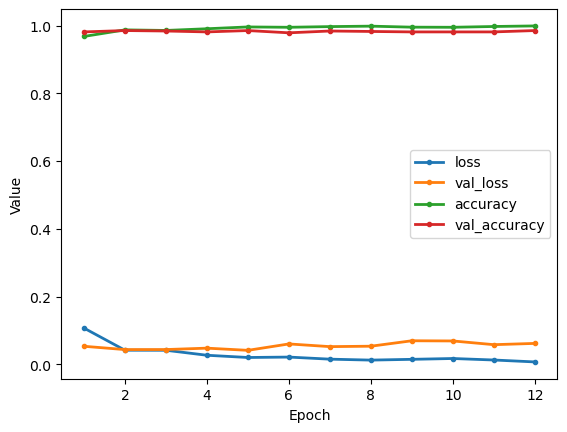

In [14]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [15]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 545us/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=3</li></ul>
</h4>

In [16]:
k = 3
X, y, features_k3 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAA,AAC,AAD,AAE,AAF,AAG,AAH,AAI,AAK,AAL,...,YYN,YYP,YYQ,YYR,YYS,YYT,YYV,YYW,YYX,YYY
703,0.0,0.0,0.0,0.0,0.0,0.005587,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.001923,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4433,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.001848,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.0,0.0,0.0,0.0,0.000000,0.002545,0.002545,0.002545,0.0,...,0.002545,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)

NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

X_train: (3745, 8658)
X_test: (937, 8658)
y_train: (3745,)
y_test: (937,)


* <span style="color: blue; font-weight: bold;">MODEL 1 : FEED-FORWARD NETWORKS</span>

In [18]:
name="FEEDFORWARD_k3"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=0.1))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])

# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 256)                 │       2,216,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,259,969 (8.62 MB)

 Trainable params: 2,259,969 (8.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 29s 643ms/step - accuracy: 0.4531 - loss: 0.6932

 7/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4852 - loss: 0.6930   

14/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5221 - loss: 0.6921

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5774 - loss: 0.6896

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6255 - loss: 0.6846

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6646 - loss: 0.6755

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6961 - loss: 0.6607

47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7028 - loss: 0.6564 - val_accuracy: 0.9933 - val_loss: 0.1401


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9844 - loss: 0.1814

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9895 - loss: 0.1327 

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9895 - loss: 0.1117

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9894 - loss: 0.0989

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9894 - loss: 0.0899

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9897 - loss: 0.0827

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9900 - loss: 0.0769

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9902 - loss: 0.0735 - val_accuracy: 0.9973 - val_loss: 0.0194


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0118

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0063 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9995 - loss: 0.0071

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0080

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0087

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9990 - loss: 0.0090

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9989 - loss: 0.0092

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0093 - val_accuracy: 0.9973 - val_loss: 0.0124


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 0.0025

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0026

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0036

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9994 - loss: 0.0044

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9992 - loss: 0.0051

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9973 - val_loss: 0.0093


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 1.0000 - loss: 0.0010

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0010 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0011

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9998 - loss: 0.0018

31/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0022

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9997 - loss: 0.0024

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9996 - loss: 0.0025

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0026 - val_accuracy: 0.9973 - val_loss: 0.0098


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.0013

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0014

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0013

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.0012

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.9973 - val_loss: 0.0114


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 3.1901e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.5938e-04 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 3.8586e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.1318e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.2621e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3054e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 4.3093e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 4.3084e-04 - val_accuracy: 0.9973 - val_loss: 0.0098


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.8812e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7835e-04 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7831e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7520e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7650e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7643e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.7609e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.7635e-04 - val_accuracy: 0.9973 - val_loss: 0.0117


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.1866e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.3281e-04 

17/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4458e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4311e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4167e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4249e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.4560e-04 - val_accuracy: 0.9973 - val_loss: 0.0092


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 8.5438e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.4368e-04 

15/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5999e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6158e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.6075e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5793e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.5459e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.5274e-04 - val_accuracy: 0.9973 - val_loss: 0.0114


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 1.0000 - loss: 1.7859e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.0899e-04 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.1123e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2337e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2551e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2450e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 1.2303e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 1.2255e-04 - val_accuracy: 0.9973 - val_loss: 0.0109


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 1.5001e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 9.5065e-05 

16/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4709e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.3284e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.4701e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 8.6893e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 1.0000 - loss: 8.8720e-05 - val_accuracy: 0.9973 - val_loss: 0.0112



[Train Accuracy: 100.00% - Test Accuracy: 99.57%]


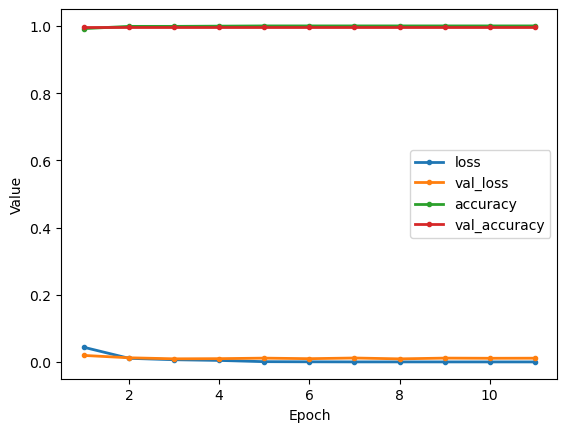

In [19]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [20]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=4</li></ul>
</h4>

In [21]:
k = 4
X, y, features_k4 = DNA.build_kmer_representation_v2(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_test.head()

,AAAA,AAAC,AAAD,AAAE,AAAF,AAAG,AAAH,AAAI,AAAK,AAAL,...,YYYM,YYYN,YYYP,YYYQ,YYYR,YYYS,YYYT,YYYV,YYYX,YYYY
703,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3994,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2765,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4433,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4601,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
NUM_CLASS  = 1
SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 2 : FEED-FORWARD NETWORKS</span>

In [23]:
name="FEEDFORWARD_k4"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))

Model: "FEEDFORWARD_k4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 256)                 │      35,509,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,550,977 (135.62 MB)

 Trainable params: 35,550,977 (135.62 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 39s 857ms/step - accuracy: 0.4531 - loss: 0.6932

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.4688 - loss: 0.6932 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4774 - loss: 0.6931

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 0.4967 - loss: 0.6931

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.5093 - loss: 0.6930

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 0.5190 - loss: 0.6929

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 0.5271 - loss: 0.6929

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5362 - loss: 0.6928

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.5455 - loss: 0.6927

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.5550 - loss: 0.6926

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 0.5650 - loss: 0.6925

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.5752 - loss: 0.6924

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.5849 - loss: 0.6922

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.5942 - loss: 0.6921

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6027 - loss: 0.6919

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6107 - loss: 0.6917

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.6183 - loss: 0.6915

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6255 - loss: 0.6912

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6326 - loss: 0.6910

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6395 - loss: 0.6907

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.6462 - loss: 0.6904

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6528 - loss: 0.6900

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6590 - loss: 0.6896

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6649 - loss: 0.6892

25/47 ━━━━━━━━━━━━━━━━━━━━ 3s 138ms/step - accuracy: 0.6704 - loss: 0.6888

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 139ms/step - accuracy: 0.6757 - loss: 0.6884

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - accuracy: 0.6809 - loss: 0.6879

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6860 - loss: 0.6873

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6908 - loss: 0.6867

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.6956 - loss: 0.6861

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7002 - loss: 0.6855

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.7047 - loss: 0.6848

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7090 - loss: 0.6841

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - accuracy: 0.7132 - loss: 0.6833

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7172 - loss: 0.6824

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7212 - loss: 0.6815

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7250 - loss: 0.6806

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7288 - loss: 0.6795

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - accuracy: 0.7324 - loss: 0.6784

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7359 - loss: 0.6773

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7393 - loss: 0.6761

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7425 - loss: 0.6748

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7457 - loss: 0.6735

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7488 - loss: 0.6721

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7518 - loss: 0.6706

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7547 - loss: 0.6691

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.7576 - loss: 0.6675

47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 171ms/step - accuracy: 0.7603 - loss: 0.6660 - val_accuracy: 0.9826 - val_loss: 0.2674


Epoch 2/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 156ms/step - accuracy: 0.9688 - loss: 0.2706

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 0.9648 - loss: 0.2727

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9679 - loss: 0.2656

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9701 - loss: 0.2576

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9723 - loss: 0.2505

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9743 - loss: 0.2440

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9761 - loss: 0.2374

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9776 - loss: 0.2315

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.9789 - loss: 0.2258

10/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.9801 - loss: 0.2205

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9811 - loss: 0.2156

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9819 - loss: 0.2110

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9827 - loss: 0.2066

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9834 - loss: 0.2024

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9840 - loss: 0.1984

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9846 - loss: 0.1944

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9850 - loss: 0.1906

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9854 - loss: 0.1871

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9857 - loss: 0.1836

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9860 - loss: 0.1803

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9862 - loss: 0.1771

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9865 - loss: 0.1740

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 0.9868 - loss: 0.1710

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9870 - loss: 0.1681

25/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9873 - loss: 0.1653

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9875 - loss: 0.1626

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9877 - loss: 0.1601

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9879 - loss: 0.1576

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9880 - loss: 0.1552

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9882 - loss: 0.1529

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9884 - loss: 0.1508

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9885 - loss: 0.1487

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9886 - loss: 0.1466

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9888 - loss: 0.1447

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9889 - loss: 0.1428

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9890 - loss: 0.1409

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9891 - loss: 0.1392

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9892 - loss: 0.1375

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9893 - loss: 0.1359

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9894 - loss: 0.1343

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9894 - loss: 0.1328

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9895 - loss: 0.1313

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9896 - loss: 0.1298

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9897 - loss: 0.1284

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9897 - loss: 0.1271

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9898 - loss: 0.1257

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9899 - loss: 0.1244

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 0.9899 - loss: 0.1232 - val_accuracy: 0.9973 - val_loss: 0.0125


Epoch 3/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 160ms/step - accuracy: 1.0000 - loss: 0.0022

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 0.0023

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0025

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - accuracy: 1.0000 - loss: 0.0026

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0027

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0027

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0027

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 0.9998 - loss: 0.0030

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 0.9996 - loss: 0.0033

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.9995 - loss: 0.0034

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9994 - loss: 0.0036

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9993 - loss: 0.0037

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9993 - loss: 0.0037

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9993 - loss: 0.0038

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9992 - loss: 0.0038

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9992 - loss: 0.0038

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 0.9992 - loss: 0.0038

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9992 - loss: 0.0038

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9992 - loss: 0.0038

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9992 - loss: 0.0038

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9992 - loss: 0.0039

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9992 - loss: 0.0039

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9991 - loss: 0.0040

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9991 - loss: 0.0040

25/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 0.9991 - loss: 0.0040

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9991 - loss: 0.0041

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 0.9990 - loss: 0.0042

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9990 - loss: 0.0042

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9990 - loss: 0.0043

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9990 - loss: 0.0043

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9990 - loss: 0.0044

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 0.9989 - loss: 0.0044

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0045

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0045

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0046

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0046

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0046

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 0.9989 - loss: 0.0047

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 0.9989 - loss: 0.0047

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0047

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0047

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0047

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9989 - loss: 0.0047

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0047

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0048

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0048

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9989 - loss: 0.0048

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 144ms/step - accuracy: 0.9989 - loss: 0.0048 - val_accuracy: 0.9920 - val_loss: 0.0205


Epoch 4/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 166ms/step - accuracy: 1.0000 - loss: 8.2162e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 8.9385e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 9.3847e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 0.0011    

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0012

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0012

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 0.0012

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0012

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 0.0012

10/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 0.0012

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 0.0012

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0012

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 138ms/step - accuracy: 1.0000 - loss: 0.0012

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0012

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0012

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0012

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 0.0012

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - accuracy: 1.0000 - loss: 0.0012

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 0.0012

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0012

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0012

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0012

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0011

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0011

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0011

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 1.0000 - loss: 0.0011

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 0.0011

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 0.0011

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 0.0011

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 0.0011

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 1.0000 - loss: 0.0011

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 148ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9973 - val_loss: 0.0080


Epoch 5/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 10s 222ms/step - accuracy: 1.0000 - loss: 6.5342e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - accuracy: 1.0000 - loss: 5.6293e-04 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.7294e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.8627e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 5.8968e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.9697e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.0104e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 6.0312e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 6.0090e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.9835e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 134ms/step - accuracy: 1.0000 - loss: 5.9539e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.9546e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 1.0000 - loss: 5.9496e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 5.9416e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 137ms/step - accuracy: 1.0000 - loss: 5.9393e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 5.9551e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 1.0000 - loss: 6.1770e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.3554e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.5047e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.6281e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.7296e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.8124e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.8870e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - accuracy: 1.0000 - loss: 6.9503e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.0058e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.0539e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 137ms/step - accuracy: 1.0000 - loss: 7.0965e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.1309e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.1629e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.1938e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.2278e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - accuracy: 1.0000 - loss: 7.2556e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.2771e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.2957e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3097e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3220e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3297e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3334e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - accuracy: 1.0000 - loss: 7.3346e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3346e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3324e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3274e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3204e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3116e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.3010e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.2897e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 7.2783e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 143ms/step - accuracy: 1.0000 - loss: 7.2673e-04 - val_accuracy: 0.9960 - val_loss: 0.0095


Epoch 6/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 150ms/step - accuracy: 1.0000 - loss: 5.9574e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 5.7461e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 5.3782e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 5.0400e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.7718e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 4.6093e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.4535e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - accuracy: 1.0000 - loss: 4.3201e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 4.2041e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 4.1059e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.0206e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.0986e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.1487e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.1844e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 4.2231e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 4.2500e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.2649e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.2987e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.5363e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 4.7401e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 4.9097e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.0563e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 5.1856e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 1.0000 - loss: 5.2977e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 5.3935e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.4837e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.5630e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.6317e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - accuracy: 1.0000 - loss: 5.6905e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 5.7441e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 133ms/step - accuracy: 1.0000 - loss: 5.7925e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8383e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.8829e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - accuracy: 1.0000 - loss: 5.9294e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 5.9708e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 134ms/step - accuracy: 1.0000 - loss: 6.0075e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0395e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0708e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - accuracy: 1.0000 - loss: 6.0975e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1206e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 1.0000 - loss: 6.1398e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1551e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1688e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1794e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1874e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1932e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 1.0000 - loss: 6.1971e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - accuracy: 1.0000 - loss: 6.2009e-04 - val_accuracy: 0.9973 - val_loss: 0.0072


Epoch 7/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 10s 230ms/step - accuracy: 1.0000 - loss: 2.7470e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 2.5350e-04 

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 2.5115e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4573e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.4148e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.3745e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 2.3273e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 2.2867e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.2456e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.2102e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1803e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1498e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1231e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1013e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 2.1178e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 2.1286e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1382e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1446e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1481e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1501e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1507e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1506e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 2.1519e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1530e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1525e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1502e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 2.1490e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.1554e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.1595e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.1628e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 2.1650e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1666e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1668e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 2.1667e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1673e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1676e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1684e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1691e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step - accuracy: 1.0000 - loss: 2.1698e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1699e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1697e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1692e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1682e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1669e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 1.0000 - loss: 2.1652e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.1654e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 1.0000 - loss: 2.1658e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 138ms/step - accuracy: 1.0000 - loss: 2.1662e-04 - val_accuracy: 0.9960 - val_loss: 0.0099


Epoch 8/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - accuracy: 1.0000 - loss: 1.5299e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.4060e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 6s 154ms/step - accuracy: 1.0000 - loss: 1.3960e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 6s 143ms/step - accuracy: 1.0000 - loss: 1.3692e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 1.3500e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.3615e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3590e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 135ms/step - accuracy: 1.0000 - loss: 1.3566e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 5s 134ms/step - accuracy: 1.0000 - loss: 1.3558e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.3538e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.3567e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms/step - accuracy: 1.0000 - loss: 1.3623e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.3663e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.3718e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.3758e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - accuracy: 1.0000 - loss: 1.3764e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.3769e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.3768e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.3763e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.3763e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step - accuracy: 1.0000 - loss: 1.3770e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.3780e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 131ms/step - accuracy: 1.0000 - loss: 1.3794e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.3817e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 131ms/step - accuracy: 1.0000 - loss: 1.3838e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.3854e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.3865e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 1.0000 - loss: 1.3876e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3882e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3888e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.3895e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3907e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3913e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3922e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3927e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3929e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3936e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3943e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.3946e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3959e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3966e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3972e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3972e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.3970e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4081e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4182e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4274e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.4362e-04 - val_accuracy: 0.9960 - val_loss: 0.0100


Epoch 9/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step - accuracy: 1.0000 - loss: 1.8685e-04

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - accuracy: 1.0000 - loss: 1.5595e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4616e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 1.0000 - loss: 1.4295e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 1.0000 - loss: 1.3921e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 133ms/step - accuracy: 1.0000 - loss: 1.3730e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3578e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 5s 131ms/step - accuracy: 1.0000 - loss: 1.3511e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 1.0000 - loss: 1.3425e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.3406e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 1.3742e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.3977e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.4123e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.4219e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.4301e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 1.4377e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4425e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4458e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.4490e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.4521e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.4524e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 130ms/step - accuracy: 1.0000 - loss: 1.4513e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 1.4495e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4477e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4471e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4460e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4449e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4445e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.4458e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4467e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 1.4474e-04

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4477e-04

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4472e-04

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4461e-04

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4452e-04

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4448e-04

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4439e-04

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 1.4425e-04

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 1.4408e-04

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4388e-04

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.4366e-04

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.4343e-04

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4322e-04

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 1.4300e-04

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4277e-04

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4254e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 1.4234e-04

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 1.4214e-04 - val_accuracy: 0.9960 - val_loss: 0.0107


Epoch 10/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 148ms/step - accuracy: 1.0000 - loss: 5.1735e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 5.8441e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.6938e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 1.0000 - loss: 6.8841e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.0402e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.1080e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 7.1988e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.2438e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 7.3649e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 7.4190e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.4351e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.4736e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.5819e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 1.0000 - loss: 7.6672e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7310e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 1.0000 - loss: 7.7795e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.8194e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 7.8489e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 7.8644e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 8.0033e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.1206e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.2286e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - accuracy: 1.0000 - loss: 8.3176e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.3892e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.4603e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5295e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.5868e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.6519e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.7177e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.7735e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 8.8239e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.8669e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.9232e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 8.9715e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.0130e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.0681e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.1159e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.1606e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.1993e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2323e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2616e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2866e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.3108e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.3422e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.3702e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.3982e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.4229e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 9.4465e-05 - val_accuracy: 0.9947 - val_loss: 0.0139


Epoch 11/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 1.0000 - loss: 7.8397e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 1.0000 - loss: 1.7432e-04

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 1.0000 - loss: 1.8065e-04

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 129ms/step - accuracy: 1.0000 - loss: 1.7655e-04

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 1.6927e-04

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.6167e-04

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 1.5600e-04

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.5048e-04

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4520e-04

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.4041e-04

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3617e-04

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - accuracy: 1.0000 - loss: 1.3253e-04

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2924e-04

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2614e-04

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 1.0000 - loss: 1.2350e-04

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.2107e-04

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 1.0000 - loss: 1.1878e-04

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.1662e-04

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1465e-04

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1278e-04

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.1105e-04

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 1.0948e-04

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 126ms/step - accuracy: 1.0000 - loss: 1.0800e-04

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 1.0000 - loss: 1.0668e-04

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.0554e-04

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.0445e-04

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step - accuracy: 1.0000 - loss: 1.0340e-04

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.0243e-04

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.0150e-04

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 1.0059e-04

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 9.9705e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.8842e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 9.7994e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 9.7165e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 9.6357e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.5582e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.4835e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.4145e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step - accuracy: 1.0000 - loss: 9.3480e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2844e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.2229e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.1619e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.1029e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 9.0461e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.9912e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.9385e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 1.0000 - loss: 8.8873e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - accuracy: 1.0000 - loss: 8.8383e-05 - val_accuracy: 0.9947 - val_loss: 0.0129


Epoch 12/100


 1/47 ━━━━━━━━━━━━━━━━━━━━ 6s 151ms/step - accuracy: 1.0000 - loss: 8.5580e-05

 2/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 7.9519e-05

 3/47 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - accuracy: 1.0000 - loss: 7.4377e-05

 4/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.9390e-05

 5/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.5714e-05

 6/47 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 1.0000 - loss: 6.4343e-05

 7/47 ━━━━━━━━━━━━━━━━━━━━ 5s 126ms/step - accuracy: 1.0000 - loss: 6.3291e-05

 8/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.2648e-05

 9/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.1907e-05

10/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.3222e-05

11/47 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 1.0000 - loss: 6.4192e-05

12/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.4815e-05

13/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5222e-05

14/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5539e-05

15/47 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 1.0000 - loss: 6.5842e-05

16/47 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 1.0000 - loss: 6.5921e-05

17/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.5938e-05

18/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.5877e-05

19/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.5846e-05

20/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.5965e-05

21/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.6014e-05

22/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.6130e-05

23/47 ━━━━━━━━━━━━━━━━━━━━ 3s 128ms/step - accuracy: 1.0000 - loss: 6.6472e-05

24/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.6792e-05

25/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.7118e-05

26/47 ━━━━━━━━━━━━━━━━━━━━ 2s 128ms/step - accuracy: 1.0000 - loss: 6.7409e-05

27/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.7697e-05

28/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.7955e-05

29/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.8147e-05

30/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.8288e-05

31/47 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step - accuracy: 1.0000 - loss: 6.8368e-05

32/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8402e-05

33/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8428e-05

34/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8427e-05

35/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8426e-05

36/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8412e-05

37/47 ━━━━━━━━━━━━━━━━━━━━ 1s 129ms/step - accuracy: 1.0000 - loss: 6.8388e-05

38/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.8343e-05

39/47 ━━━━━━━━━━━━━━━━━━━━ 1s 130ms/step - accuracy: 1.0000 - loss: 6.8278e-05

40/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.8191e-05

41/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.8103e-05

42/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.8016e-05

43/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.7914e-05

44/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.7830e-05

45/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.7768e-05

46/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.7718e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 1.0000 - loss: 6.7661e-05

47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 1.0000 - loss: 6.7607e-05 - val_accuracy: 0.9960 - val_loss: 0.0112



[Train Accuracy: 100.00% - Test Accuracy: 99.47%]


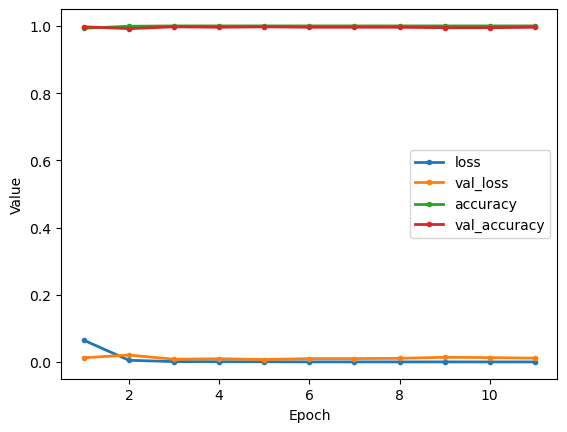

In [24]:
VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [25]:
VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])

 1/30 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

 6/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

11/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

16/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

25/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


 1/30 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step

 5/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

 9/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

14/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

28/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [26]:
report.save()

Report saved as Output/Reports/WOX/report_RB94LWIM.html


<h4 style="background-color: #80c4e6; display: flex;">
    <ul><li>k=5</li></ul>
</h4>

In [27]:
#k = 5
#X, y, features_k5 = DNA.build_kmer_representation_v1(dataset, domaine=domaine, k=k, dtypes=['float16', 'int8'], asCudaDF=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#X_test.head()

In [28]:
#NUM_CLASS  = 1
#SEQ_LENGTH = X_train.shape[1]

* <span style="color: blue; font-weight: bold;">MODEL 3 : FEED-FORWARD NETWORKS</span>

In [29]:
"""
name="FEEDFORWARD_k5"
def feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):
    model = Sequential(name=name)
    model.add(Input(shape=(SEQ_LENGTH,)))
    model.add(Dense(2*256, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=0.2))
    model.add(Dense(num_output, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# Build & train the model
model = feedforward_net1()
stop_callback = early_stopping(patience=10)
save_callback = model_checkpoint(name)

X_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)
history = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])


# Evaluate and score
test_scores = model.evaluate(X_test, y_test, verbose=0)
train_score = history.history.get('accuracy')[-1]
print("\n[Train Accuracy: {:.2f}% - Test Accuracy: {:.2f}%]".format(train_score*100, test_scores[1]*100))"""

'\nname="FEEDFORWARD_k5"\ndef feedforward_net1(name=name, num_output=NUM_CLASS, seq_length=SEQ_LENGTH):\n    model = Sequential(name=name)\n    model.add(Input(shape=(SEQ_LENGTH,)))\n    model.add(Dense(2*256, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(128, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(64, activation=\'relu\'))\n    model.add(Dropout(rate=0.2))\n    model.add(Dense(num_output, activation=\'sigmoid\'))\n    model.compile(loss=\'binary_crossentropy\', optimizer=\'adam\', metrics=[\'accuracy\'])\n    model.summary()\n    return model\n\n# Build & train the model\nmodel = feedforward_net1()\nstop_callback = early_stopping(patience=10)\nsave_callback = model_checkpoint(name)\n\nX_t, X_v, y_t, y_v = train_test_split(X_train, y_train, train_size=0.8, stratify=y_train)\nhistory = model.fit(X_t, y_t, validation_data=(X_v, y_v), epochs=100, batch_size=64, callbacks=[stop_callback, save_callback])\n\n\n# Evaluate an

In [30]:
#VISU.plot_curve(history, ['loss', 'val_loss', 'accuracy', 'val_accuracy'])

In [31]:
#VISU.test_report(X_test, y_test, model=model,  args=[model.name, test_scores[1]*100]) 
#report.add_report(X_test, y_test, model=model, history=history, args=[model.name, "---"])
#report.save()

In [32]:
# END

In [33]:
###################################### DEBUG TO OPTIMIZE K-MER LOEADER FUNCTION ###########################################